# Imports 

In [25]:
# Standard library imports
from time import time
import numpy as np
import evaluate
import matplotlib as pt

# Third-party library imports
from datasets import Dataset, DatasetDict, load_dataset
from evaluate import load
from peft import LoraConfig, PeftModel, get_peft_model
from transformers import (
    TrainerCallback,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    AutoTokenizer,
    GenerationConfig,
    M2M100Config,
    M2M100ForConditionalGeneration,
    M2M100Tokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    pipeline,
)

# Local application/library specific imports
import torch

# 1. Data loading and spliting

In [26]:
percent_data_select = "train[:100]" # add percent sign ie. "train[:20%]" to select that percent of data 
# Load only 20% of the dataset
dataset = load_dataset("csv", data_files={"train": "../Datasets/processed_data.csv"}, split=percent_data_select)

# Split into train and test sets (e.g., 80% train, 20% test)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

# Further split the test set into validation and test (e.g., 50-50 split of the 20%)
validation_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# Combine splits into a DatasetDict
raw_dataset = {
    "train": train_test_split["train"],
    "validation": validation_test_split["train"],
    "test": validation_test_split["test"]
}

dataset = DatasetDict(raw_dataset)

# Inspect the resulting dataset
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['English', 'Hindi'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['English', 'Hindi'],
        num_rows: 10
    })
    test: Dataset({
        features: ['English', 'Hindi'],
        num_rows: 10
    })
})


In [27]:
print(dataset['train'][0])
print(dataset['train'][1])
print(dataset['train'][2])
print(dataset['train'][3])

{'English': 'for more detailed figures from 2011 census, see this table.', 'Hindi': '2011 की जनगणना से अधिक विस्तृत आंकड़ों के लिए, इस तालिका को देखें।'}
{'English': 'death is seen as a boundary to another world.', 'Hindi': 'मौत एक और दुनिया के लिए एक सीमा के रूप में देखा जाता है।'}
{'English': 'george miller always wanted one person to do both .', 'Hindi': 'जॉर्ज मिलर हमेशा एक व्यक्ति को दोनों करना चाहते थे।'}
{'English': 'the targets of the german aircraft were actually the rail lines and bridges.', 'Hindi': 'जर्मन विमानों के लक्ष्य वास्तव में रेल लाइन और पुल थे।'}


# 2. Facebook / M2M100 418M
- M2M-100 stands for Massively Multilingual Model with 100 languages.
- 418M refers to the model size in terms of the number of parameters. Parameters are the learnable weights within the model's neural network. A larger number of parameters generally allows the model to learn more complex patterns and achieve higher accuracy.

## 2.1 Comparing Tokenizers 
- Our approach will involve a systematic comparison of tokenization strategies, paying close attention to how each method handles linguistic characteristics specific to Hindi and English.

#### 2.1.1 AutoTokenizer

In [28]:
model_ID = "facebook/m2m100_418M"  # Replace with your desired model
model = AutoModelForSeq2SeqLM.from_pretrained(model_ID)
tokenizer = AutoTokenizer.from_pretrained(model_ID, src_lang="en", tgt_lang="hi")
# Create a GenerationConfig with the desired parameters

In [29]:
# Sample data from the dataset
sample = dataset["train"][12]  # Replace with an actual sample index
input_text = "translate Hindi to English: " + sample["Hindi"]
target_text = sample["English"]

# Tokenize inputs and targets
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
with tokenizer.as_target_tokenizer():
    targets = tokenizer(target_text, return_tensors="pt", padding=True, truncation=True)

# Convert token IDs back to tokens
input_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
target_tokens = tokenizer.convert_ids_to_tokens(targets["input_ids"][0])

# Print the results for inspection
print("Original Hindi Input:", input_text)
print("Input Tokens:", input_tokens)
print("Decoded Input Text:", tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=False))
print("\nOriginal English Target:", target_text)
print("Target Tokens:", target_tokens)
print("Decoded Target Text:", tokenizer.decode(targets["input_ids"][0], skip_special_tokens=False))

Original Hindi Input: translate Hindi to English: इस काम के बोझ को मेरे साथ कौन साझा करेगा?
Input Tokens: ['__en__', '▁trans', 'late', '▁Hindi', '▁to', '▁English', ':', '▁इस', '▁काम', '▁के', '▁बो', 'झ', '▁को', '▁मेरे', '▁साथ', '▁कौन', '▁सा', 'झा', '▁करे', 'गा', '?', '</s>']
Decoded Input Text: __en__ translate Hindi to English: इस काम के बोझ को मेरे साथ कौन साझा करेगा?</s>

Original English Target: who will share the burden of this work with me?
Target Tokens: ['__hi__', '▁who', '▁will', '▁share', '▁the', '▁bur', 'den', '▁of', '▁this', '▁work', '▁with', '▁me', '?', '</s>']
Decoded Target Text: __hi__ who will share the burden of this work with me?</s>


 **Why are "__hi__" and "__en__" appearing before the English and Hindi sentences, respectively?**

These special tokens, "__hi__" and "__en__", are often used in machine translation tasks to explicitly indicate the **source language** and **target language**. They serve as markers for the model to understand which language it's currently processing.

##### Here's a breakdown of their functions:

* **__hi__ and __en__: Language Identifiers:**
   - **__hi__**: This token typically represents the Hindi language. When placed at the beginning of a sentence, it tells the model that the following text is in Hindi and should be translated into the target language (in this case, English).
   - **__en__**: Similarly, "__en__" indicates that the following text is in English. It might be used in scenarios where the model is asked to translate from English to Hindi or for tasks like language identification.

##### Why are they added?

* **Clarity for the Model:** These markers provide clear and explicit information to the model about the language of the input and output sequences. This helps the model to better understand the context and improve the accuracy of its translations.
* **Handling Multiple Language Pairs:** In multilingual models, these tokens can be used to handle various language pairs. For example, if the model is trained on multiple language pairs (e.g., English-French, English-Spanish), these tokens can help the model distinguish between the different language pairs.
* **Facilitating Language Identification:** In some cases, these tokens can also be used for language identification tasks, where the model is asked to determine the language of a given text.

##### In above given example:

* **"__en__ translate Hindi to English: जॉर्ज मिलर हमेशा एक व्यक्ति को दोनों करना चाहते थे।"**: This part tells the model that the following text is in English and the task is to translate the Hindi text that follows.
* **"__hi__ george miller always wanted one person to do both ."**: This indicates that the following text is the English translation of the preceding Hindi text.

**Note:** The specific tokens used (e.g., "__hi__", "__en__") can vary depending on the pre-training data and the specific configuration of the model. However, the general concept of using special tokens to indicate language remains consistent.

By understanding the role of these tokens, one can better interpret the model's output and fine-tune your training data for more accurate translations.


#### 2.1.2 M2M100 Tokenizer

In [30]:
model_ID_fb = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M",)
tokenizer_fb = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en", tgt_lang="hi")


In [31]:
# Sample data from the dataset
sample2 = dataset["train"][12]  # Replace with an actual sample index
input_text2 = "translate Hindi to English: " + sample["Hindi"]
target_text2 = sample["English"]

# Tokenize inputs and targets
inputs2 = tokenizer_fb(input_text2, return_tensors="pt", padding=True, truncation=True)
with tokenizer_fb.as_target_tokenizer():
    targets2 = tokenizer_fb(target_text2, return_tensors="pt", padding=True, truncation=True)

# Convert token IDs back to tokens
input_tokens2 = tokenizer_fb.convert_ids_to_tokens(inputs2["input_ids"][0])
target_tokens2 = tokenizer_fb.convert_ids_to_tokens(targets2["input_ids"][0])

# Print the results for inspection
print("Original Hindi Input:", input_text2)
print("Input Tokens:", input_tokens2)
print("Decoded Input Text:", tokenizer_fb.decode(inputs2["input_ids"][0], skip_special_tokens=False))
print("\nOriginal English Target:", target_text2)
print("Target Tokens:", target_tokens2)
print("Decoded Target Text:", tokenizer_fb.decode(targets2["input_ids"][0], skip_special_tokens=False))

Original Hindi Input: translate Hindi to English: इस काम के बोझ को मेरे साथ कौन साझा करेगा?
Input Tokens: ['__en__', '▁trans', 'late', '▁Hindi', '▁to', '▁English', ':', '▁इस', '▁काम', '▁के', '▁बो', 'झ', '▁को', '▁मेरे', '▁साथ', '▁कौन', '▁सा', 'झा', '▁करे', 'गा', '?', '</s>']
Decoded Input Text: __en__ translate Hindi to English: इस काम के बोझ को मेरे साथ कौन साझा करेगा?</s>

Original English Target: who will share the burden of this work with me?
Target Tokens: ['__hi__', '▁who', '▁will', '▁share', '▁the', '▁bur', 'den', '▁of', '▁this', '▁work', '▁with', '▁me', '?', '</s>']
Decoded Target Text: __hi__ who will share the burden of this work with me?</s>


In [32]:
print(tokenizer.special_tokens_map)  # Check special tokens (e.g., <pad>, <unk>, etc.)


{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'additional_special_tokens': ['__af__', '__am__', '__ar__', '__ast__', '__az__', '__ba__', '__be__', '__bg__', '__bn__', '__br__', '__bs__', '__ca__', '__ceb__', '__cs__', '__cy__', '__da__', '__de__', '__el__', '__en__', '__es__', '__et__', '__fa__', '__ff__', '__fi__', '__fr__', '__fy__', '__ga__', '__gd__', '__gl__', '__gu__', '__ha__', '__he__', '__hi__', '__hr__', '__ht__', '__hu__', '__hy__', '__id__', '__ig__', '__ilo__', '__is__', '__it__', '__ja__', '__jv__', '__ka__', '__kk__', '__km__', '__kn__', '__ko__', '__lb__', '__lg__', '__ln__', '__lo__', '__lt__', '__lv__', '__mg__', '__mk__', '__ml__', '__mn__', '__mr__', '__ms__', '__my__', '__ne__', '__nl__', '__no__', '__ns__', '__oc__', '__or__', '__pa__', '__pl__', '__ps__', '__pt__', '__ro__', '__ru__', '__sd__', '__si__', '__sk__', '__sl__', '__so__', '__sq__', '__sr__', '__ss__', '__su__', '__sv__', '__sw__', '__ta__', 

In [33]:
print(tokenizer_fb.special_tokens_map)  # Check special tokens (e.g., <pad>, <unk>, etc.)


{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'additional_special_tokens': ['__af__', '__am__', '__ar__', '__ast__', '__az__', '__ba__', '__be__', '__bg__', '__bn__', '__br__', '__bs__', '__ca__', '__ceb__', '__cs__', '__cy__', '__da__', '__de__', '__el__', '__en__', '__es__', '__et__', '__fa__', '__ff__', '__fi__', '__fr__', '__fy__', '__ga__', '__gd__', '__gl__', '__gu__', '__ha__', '__he__', '__hi__', '__hr__', '__ht__', '__hu__', '__hy__', '__id__', '__ig__', '__ilo__', '__is__', '__it__', '__ja__', '__jv__', '__ka__', '__kk__', '__km__', '__kn__', '__ko__', '__lb__', '__lg__', '__ln__', '__lo__', '__lt__', '__lv__', '__mg__', '__mk__', '__ml__', '__mn__', '__mr__', '__ms__', '__my__', '__ne__', '__nl__', '__no__', '__ns__', '__oc__', '__or__', '__pa__', '__pl__', '__ps__', '__pt__', '__ro__', '__ru__', '__sd__', '__si__', '__sk__', '__sl__', '__so__', '__sq__', '__sr__', '__ss__', '__su__', '__sv__', '__sw__', '__ta__', 

**Both tokenizers i.e. pretrained models and model-specific tokenizers can yield similar outputs in many scenarios, but this isn't a universal rule.**

  -  ***When comparing different models, such as `M2M100` and `Google's T5 small`, we'll encounter variations in how unknown words are processed. The Google T5 small model, for instance, tends to generate more `<unk>` tokens when encountering vocabulary outside its training set, which can pose challenges for translation*** 

## 2.2 text preprocessing



**Importance of Text Preprocessing:**

1. **Converting Text to Numbers:** Machine learning models can't directly understand raw text. Preprocessing transforms text into numerical representations (tokens) that the model can process.

2. **Normalization and Consistency:** Text data can have inconsistencies like capitalization, punctuation, and variations in word forms (e.g., singular vs. plural). Preprocessing steps like lowercasing or stemming/lemmatization can address these issues, promoting consistency in the data.

3. **Feature Engineering:** Preprocessing can create new features for the model. In your example, prepending "translate Hindi to English: " to the source sentences might help the model understand the context of translation.

4. **Handling Text Length:** Different models have limitations on input and output lengths. Preprocessing techniques like truncation and padding ensure your data adheres to these limitations.

In [34]:

def preprocess_function(examples, src_lang, tgt_lang):
    inputs = [f"translate {src_lang} to {tgt_lang}: " + ex for ex in examples[src_lang]]
    targets = examples[tgt_lang]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [35]:
tokenized_datasets_hindi_to_english = dataset.map(lambda x: preprocess_function(x, "Hindi", "English"), batched=True)
tokenized_datasets_english_to_hindi = dataset.map(lambda x: preprocess_function(x, "English", "Hindi"), batched=True)

In [38]:
# Inspect the first example
for idx in range(3):  # Print first 3 examples as a sample
    print(f"Original Hindi: {dataset['train'][idx]['Hindi']}")
    print(f"Original English: {dataset['train'][idx]['English']}")

    # Tokenized inputs
    tokenized_input = tokenized_datasets_hindi_to_english["train"][idx]["input_ids"]
    print(f"Tokenized Input IDs: {tokenized_input}")
    print(f"Decoded Input: {tokenizer.decode(tokenized_input, skip_special_tokens=False)}")

    # Tokenized outputs
    tokenized_label = tokenized_datasets_hindi_to_english["train"][idx]["labels"]
    print(f"Tokenized Label IDs: {tokenized_label}")
    print(f"Decoded Label: {tokenizer.decode(tokenized_label, skip_special_tokens=False)}")

    print("=" * 10)

Original Hindi: 2011 की जनगणना से अधिक विस्तृत आंकड़ों के लिए, इस तालिका को देखें।
Original English: for more detailed figures from 2011 census, see this table.
Tokenized Input IDs: [128022, 5815, 80447, 11631, 128, 18006, 9, 2294, 783, 15258, 2568, 3207, 1383, 1044, 21283, 118809, 58278, 1843, 15694, 8967, 1839, 456, 3460, 4, 5163, 48867, 8964, 929, 78705, 209, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded Input: __en__ translate Hindi to English: 2011 की जनगणना से अधिक विस्तृत आंकड़ों के लिए, इस तालिका को देखें।</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

**Specific Breakdown to Code:**

- **`inputs = ["translate Hindi to English: " + ex for ex in examples["Hindi"]]`**: This line creates a new list (`inputs`) by prepending a context string to each sentence in the `Hindi` column of the dataset.

- **`model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")`**: This tokenizes the `inputs` list, converting them into numerical representations using the `tokenizer`. The `max_length` argument limits the length of each sequence, and `truncation=True` ensures sequences exceeding the limit are shortened. `padding="max_length"` pads shorter sequences with special tokens to create a uniform length.

- **`with tokenizer.as_target_tokenizer():`**: This context manager configures the tokenizer for handling the target language (English) by setting the appropriate attributes.

- **`labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")`**: This tokenizes the target sentences (`English`) with similar parameters as the input.

- **`model_inputs["labels"] = labels["input_ids"]`**: This adds the tokenized target sentence IDs (stored as `input_ids` in the `labels` dictionary) as a new key "labels" within the `model_inputs` dictionary.

- **`tokenized_datasets = dataset.map(preprocess_function, batched=True)`**: This line applies the `preprocess_function` to each element of the dataset (`dataset`) in batches using `batched=True` for efficiency. The resulting processed data is stored in `tokenized_datasets`.

In summary, this text preprocessing step transforms your raw text data into a format suitable for training your machine translation model. It ensures consistency, handles sequence lengths, and potentially adds contextual information to aid the translation process.

## 2.3 Data collator


In machine learning, particularly for transformer models, a data collator plays a crucial role in preparing batches of data for training. It's essentially a function that takes individual samples and combines them into batches in a way that's efficient and optimized for the model's processing.


For sequence-to-sequence tasks like translation, a specialized data collator (often DataCollatorForSeq2Seq) becomes critical. It ensures that:
- Source and target sequences are properly aligned
- Padding is applied consistently
- Attention mechanisms can correctly ignore padded tokens
- Labels are prepared in a format that allows for loss calculation during training



Without a proper data collator, you'd need to manually handle sequence padding, masking, and batch preparation, which would be computationally expensive and error-prone.

In [39]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_ID)

## 2.4 BLEU (Bilingual Evaluation Understudy): 


In [40]:
metric = evaluate.load("sacrebleu")

In [41]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds, tokenizer, metric):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

## 2.5 Fine Tuning


In [42]:
training_args = Seq2SeqTrainingArguments(
    output_dir="../Model/fb/Base/Checkpoint/",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_hindi_to_english["train"],
    eval_dataset=tokenized_datasets_hindi_to_english["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, tokenizer, metric),
)

trainer.train()

# Fine-tune for English to Hindi
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_english_to_hindi["train"],
    eval_dataset=tokenized_datasets_english_to_hindi["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, tokenizer, metric),
)

trainer.train()

C:\Users\akthe\AppData\Local\Temp\ipykernel_9980\902773401.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


  0%|          | 0/30 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 9.094779968261719, 'eval_bleu': 6.0161, 'eval_gen_len': 23.6, 'eval_runtime': 17.2114, 'eval_samples_per_second': 0.581, 'eval_steps_per_second': 0.116, 'epoch': 1.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 7.14027214050293, 'eval_bleu': 20.4894, 'eval_gen_len': 22.2, 'eval_runtime': 32.4599, 'eval_samples_per_second': 0.308, 'eval_steps_per_second': 0.062, 'epoch': 2.0}


c:\Users\akthe\miniconda3\envs\WPanda\Lib\site-packages\transformers\modeling_utils.py:2748: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.toke

  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 6.743070602416992, 'eval_bleu': 22.7465, 'eval_gen_len': 18.4, 'eval_runtime': 16.9232, 'eval_samples_per_second': 0.591, 'eval_steps_per_second': 0.118, 'epoch': 3.0}
{'train_runtime': 433.9725, 'train_samples_per_second': 0.553, 'train_steps_per_second': 0.069, 'train_loss': 8.740756225585937, 'epoch': 3.0}


C:\Users\akthe\AppData\Local\Temp\ipykernel_9980\902773401.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


  0%|          | 0/30 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 6.0962629318237305, 'eval_bleu': 24.2291, 'eval_gen_len': 24.1, 'eval_runtime': 34.8976, 'eval_samples_per_second': 0.287, 'eval_steps_per_second': 0.057, 'epoch': 1.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 5.827173233032227, 'eval_bleu': 12.9002, 'eval_gen_len': 45.4, 'eval_runtime': 123.0081, 'eval_samples_per_second': 0.081, 'eval_steps_per_second': 0.016, 'epoch': 2.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 5.736571788787842, 'eval_bleu': 15.8606, 'eval_gen_len': 38.4, 'eval_runtime': 80.5008, 'eval_samples_per_second': 0.124, 'eval_steps_per_second': 0.025, 'epoch': 3.0}
{'train_runtime': 518.8838, 'train_samples_per_second': 0.463, 'train_steps_per_second': 0.058, 'train_loss': 6.194696044921875, 'epoch': 3.0}


TrainOutput(global_step=30, training_loss=6.194696044921875, metrics={'train_runtime': 518.8838, 'train_samples_per_second': 0.463, 'train_steps_per_second': 0.058, 'total_flos': 65013138063360.0, 'train_loss': 6.194696044921875, 'epoch': 3.0})

## 2.6 Saving Finetuned Model


In [43]:
trainer.save_model("../Model/fb/Base/M2M100/")
tokenizer.save_pretrained("../Model/fb/Base/M2M100/")


('../Model/fb/Base/M2M100/tokenizer_config.json',
 '../Model/fb/Base/M2M100/special_tokens_map.json',
 '..\\Model\\fb\\Base\\M2M100\\vocab.json',
 '..\\Model\\fb\\Base\\M2M100\\sentencepiece.bpe.model',
 '../Model/fb/Base/M2M100/added_tokens.json')

## 2.7 laoding & testing Finetuned Model


In [45]:
from transformers import pipeline
text = 'break a leg'
translator = pipeline("translation_en_to_hi", model="../Model/fb/Base/M2M100/")
translator(text)


Device set to use cuda:0


[{'translation_text': 'एक पैर तोड़ना'}]

In [44]:
# Test Hindi to English
translator_hindi_to_english = pipeline("translation_hi_to_en", model="../Model/fb/Base/M2M100/")
result_hindi_to_english = translator_hindi_to_english("यह एक परीक्षण है")
print(result_hindi_to_english)

# Test English to Hindi
translator_english_to_hindi = pipeline("translation_en_to_hi", model="../Model/fb/Base/M2M100/")
result_english_to_hindi = translator_english_to_hindi("This is a test")
print(result_english_to_hindi)

Device set to use cuda:0


[{'translation_text': 'It is a test.'}]


Device set to use cuda:0


[{'translation_text': 'यह एक परीक्षण है।'}]


In [19]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# 3.	Facebook / M2M100 418M + LoRa
- LoRA (Low-Rank Adaptation) refers to a parameter-efficient fine-tuning technique.


![alt text](image.png)

In the context of Large Language Models (LLMs), LoRA (Low-Rank Adaptation) refers to a parameter-efficient fine-tuning technique. 

**Key Concepts:**

* **Fine-tuning:** LLMs are often pre-trained on massive datasets. Fine-tuning involves adapting these pre-trained models to specific tasks or domains using smaller, more relevant datasets.
* **Parameter-Efficiency:** Fine-tuning LLMs can be computationally expensive, especially for very large models. LoRA addresses this by significantly reducing the number of parameters that need to be updated during fine-tuning.

**How LoRA Works:**

Instead of fine-tuning all the parameters of the base LLM, LoRA introduces two small, trainable matrices (A and B) for each attention layer:

1. **Decomposition:** The update to the original weight matrix (W) is approximated as the product of these two smaller matrices: W' = W + A * B.
2. **Reduced Parameters:** Since A and B have significantly fewer parameters than the original weight matrix, the overall number of trainable parameters is drastically reduced.
3. **Fine-tuning:** Only the parameters of A and B are trained during fine-tuning, while the original weights of the base LLM remain frozen.

**Benefits of LoRA:**

* **Reduced Training Time and Cost:** By training only a small subset of parameters, LoRA significantly reduces training time and computational resources.
* **Improved Efficiency:** The smaller number of parameters leads to faster inference times.
* **Preserving Base Model:** Since the base model's weights are frozen, it retains its general knowledge and capabilities while being adapted to the specific task.
* **Easier Deployment:** Smaller models are easier to deploy and run on devices with limited resources.

**Applications:**

LoRA has been successfully applied to a wide range of LLM fine-tuning tasks, including:

* **Domain Adaptation:** Adapting LLMs to specific domains like finance, medicine, or law.
* **Task-Specific Fine-tuning:** Fine-tuning LLMs for specific tasks such as question answering, text summarization, and code generation.
* **Personalization:** Creating personalized LLMs for individual users or groups.

**In summary:**

LoRA is a powerful technique that enables efficient and effective fine-tuning of LLMs. By significantly reducing the number of trainable parameters, LoRA makes it possible to customize large models for specific applications while minimizing training costs and preserving the valuable knowledge of the base model.


## 3.1 Model self attention layer
- it is crucial to know self attention module defined as in lora weight changes of these metrics are tracked

In [20]:
# Access the model's named modules
for name, module in model.named_modules():
    print(name, module)

 M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100SdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  

## 3.2 Defining lora Config


In [21]:
model_ID = "facebook/m2m100_418M"  # Replace with your desired model
model_lora = AutoModelForSeq2SeqLM.from_pretrained(model_ID)
tokenizer_lora = AutoTokenizer.from_pretrained(model_ID, src_lang="en", tgt_lang="hi")
# Create a GenerationConfig with the desired parameters

In [22]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=4,  # Low rank (fewer trainable parameters)
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Apply LoRA to attention layers (query and value)
    bias="none",  # Specify which biases to train
    task_type="SEQ_2_SEQ_LM",  # Task type (sequence-to-sequence)
)

# Wrap the base model with LoRA
model_lora = get_peft_model(model, lora_config)

## 3.3 loading and spliting datasets for lora 


In [23]:
percent_data_select_lora = "train[:200]" # add percent sign ie. "train[:20%]" to select that percent of data 
# Load only 20% of the dataset
dataset_lora = load_dataset("csv", data_files={"train": "../Datasets/processed_data.csv"}, split=percent_data_select)

# Split into train and test sets (e.g., 80% train, 20% test)
train_test_split = dataset_lora.train_test_split(test_size=0.2, seed=42)

# Further split the test set into validation and test (e.g., 50-50 split of the 20%)
validation_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# Combine splits into a DatasetDict
raw_dataset = {
    "train": train_test_split["train"],
    "validation": validation_test_split["train"],
    "test": validation_test_split["test"]
}

dataset_lora = DatasetDict(raw_dataset)

# Inspect the resulting dataset
print(dataset_lora)

DatasetDict({
    train: Dataset({
        features: ['English', 'Hindi'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['English', 'Hindi'],
        num_rows: 10
    })
    test: Dataset({
        features: ['English', 'Hindi'],
        num_rows: 10
    })
})


## 3.4 Tokenising dataset for lora 


In [24]:
def preprocess_function(examples):
    inputs = ["translate Hindi to English: " + ex for ex in examples["Hindi"]]
    targets = examples["English"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
tokenized_dataset_lora = dataset_lora.map(preprocess_function, batched=True)


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

c:\Users\akthe\miniconda3\envs\WPanda\Lib\site-packages\transformers\tokenization_utils_base.py:3957: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [25]:
tokenized_dataset_lora

DatasetDict({
    train: Dataset({
        features: ['English', 'Hindi', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['English', 'Hindi', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
    test: Dataset({
        features: ['English', 'Hindi', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
})

## 3.5 Data collator

In [26]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_lora, model=model_lora)

## 3.6 FineTuning


In [27]:
training_args = Seq2SeqTrainingArguments(
    output_dir="../Model/fb/LoRa/Checkpoint/",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    save_safetensors=False,
    predict_with_generate=True,
    fp16=True, #change to bf16=True for XPU
    
)

trainer = Seq2SeqTrainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_dataset_lora["train"],
    eval_dataset=tokenized_dataset_lora["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)

trainer.train()

C:\Users\akthe\AppData\Local\Temp\ipykernel_20844\1405674414.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


  0%|          | 0/40 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 6.735177993774414, 'eval_bleu': 22.9911, 'eval_gen_len': 18.5, 'eval_runtime': 5.979, 'eval_samples_per_second': 1.673, 'eval_steps_per_second': 0.335, 'epoch': 1.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 6.730266094207764, 'eval_bleu': 22.9911, 'eval_gen_len': 18.5, 'eval_runtime': 5.7974, 'eval_samples_per_second': 1.725, 'eval_steps_per_second': 0.345, 'epoch': 2.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 6.725201606750488, 'eval_bleu': 22.9911, 'eval_gen_len': 18.5, 'eval_runtime': 19.5596, 'eval_samples_per_second': 0.511, 'eval_steps_per_second': 0.102, 'epoch': 3.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 6.723258972167969, 'eval_bleu': 22.9911, 'eval_gen_len': 18.5, 'eval_runtime': 12.9632, 'eval_samples_per_second': 0.771, 'eval_steps_per_second': 0.154, 'epoch': 4.0}
{'train_runtime': 176.0191, 'train_samples_per_second': 1.818, 'train_steps_per_second': 0.227, 'train_loss': 6.858437347412109, 'epoch': 4.0}


TrainOutput(global_step=40, training_loss=6.858437347412109, metrics={'train_runtime': 176.0191, 'train_samples_per_second': 1.818, 'train_steps_per_second': 0.227, 'total_flos': 86829139230720.0, 'train_loss': 6.858437347412109, 'epoch': 4.0})

## 3.7 Saving Finetuned Model


In [28]:
model_lora.merge_and_unload()
model_lora.save_pretrained("../Model/fb/LoRa/M2M100/")
tokenizer.save_pretrained("../Model/fb/LoRa/M2M100/")


('../Model/fb/LoRa/M2M100/tokenizer_config.json',
 '../Model/fb/LoRa/M2M100/special_tokens_map.json',
 '..\\Model\\fb\\LoRa\\M2M100\\vocab.json',
 '..\\Model\\fb\\LoRa\\M2M100\\sentencepiece.bpe.model',
 '../Model/fb/LoRa/M2M100/added_tokens.json')

## 3.8 Testing Finetuned Model


In [29]:
# Initialize the translation pipeline
translator = pipeline("translation_en_to_hi", model="../Model/fb/LoRa/M2M100/", tokenizer="../Model/fb/LoRa/M2M100/")

# Test translation
text = "break a leg"
translated_text = translator(text)

print(translated_text)


Device set to use cuda:0


[{'translation_text': 'एक पैर तोड़ना'}]


# 4. Comparision




- **BLEU Score Comparison**:
  - A bar chart showing the BLEU scores for the untrained model, fine-tuned model, and LoRA model.
  - You should see that the fine-tuned model and LoRA model perform better than the untrained model.

- **Loss Comparison**:
  - A bar chart showing the loss for the untrained model, fine-tuned model, and LoRA model.
  - The fine-tuned model and LoRA model should have lower loss compared to the untrained model.




c:\Users\akthe\miniconda3\envs\WPanda\Lib\site-packages\peft\peft_model.py:609: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.encoder.layers.1.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.encoder.layers.1.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.encoder.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.encoder.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.encoder.layers.2.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.encoder.layers.2.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.encod

  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

  0%|          | 0/2 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


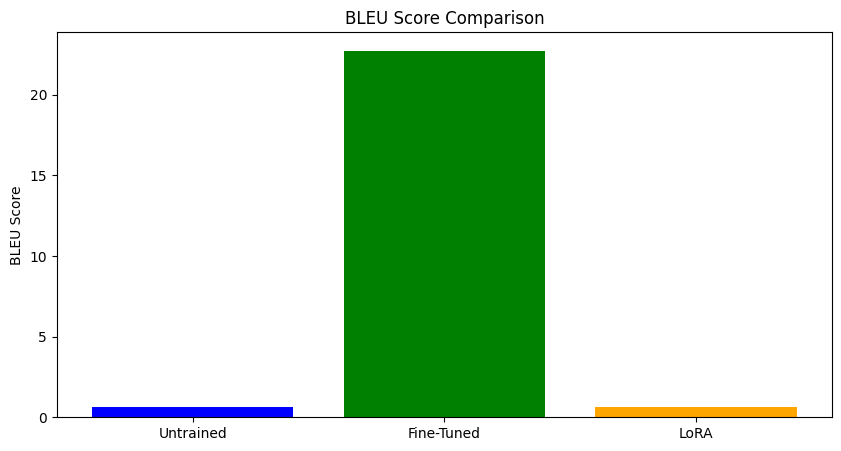

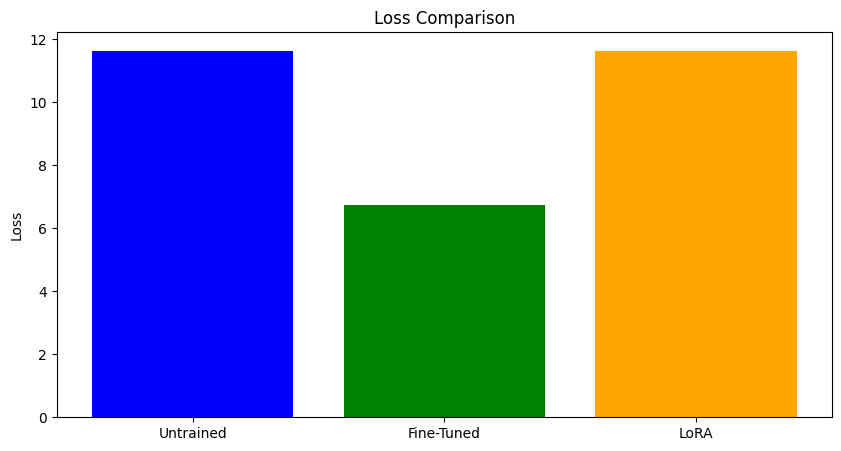

In [30]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/m2m100_418M")

# Load the datasets
test_dataset = tokenized_datasets["test"]

# Define a function to evaluate a model
def evaluate_model(model, test_dataset):
    trainer = Seq2SeqTrainer(
        model=model,
        args=Seq2SeqTrainingArguments(output_dir="../Model/temp", per_device_eval_batch_size=8, predict_with_generate=True),
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    results = trainer.evaluate()
    return results["eval_bleu"], results["eval_loss"]

# Load the untrained model
untrained_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/m2m100_418M")

# Load the fine-tuned model
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("../Model/fb/Base/M2M100/")

# Load the fine-tuned LoRA model
lora_model = PeftModel.from_pretrained(
    AutoModelForSeq2SeqLM.from_pretrained("facebook/m2m100_418M"),
    "../Model/fb/LoRa/M2M100/"
)

# Evaluate all models
untrained_bleu, untrained_loss = evaluate_model(untrained_model, test_dataset)
fine_tuned_bleu, fine_tuned_loss = evaluate_model(fine_tuned_model, test_dataset)
lora_bleu, lora_loss = evaluate_model(lora_model, test_dataset)

# Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.bar(["Untrained", "Fine-Tuned", "LoRA"], [untrained_bleu, fine_tuned_bleu, lora_bleu], color=["blue", "green", "orange"])
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison")
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.bar(["Untrained", "Fine-Tuned", "LoRA"], [untrained_loss, fine_tuned_loss, lora_loss], color=["blue", "green", "orange"])
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.show()

# 5 Saving Desire Model to Hugging Face library.

In [33]:
from huggingface_hub import notebook_login
notebook_login()